In [1]:
import pandas as pd
import os
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

In [2]:
state_abv = {
    '2': 'AK',
    '1': 'AL',
    '5': 'AR',
    '4': 'AZ',
    '6': 'CA',
    '8': 'CO',
    '9': 'CT',
    '11': 'DC',
    '10': 'DE',
    '12': 'FL',
    '13': 'GA',
    '15': 'HI',
    '19': 'IA',
    '16': 'ID',
    '17': 'IL',
    '18': 'IN',
    '20': 'KS',
    '21': 'KY',
    '22': 'LA',
    '25': 'MA',
    '24': 'MD',
    '23': 'ME',
    '26': 'MI',
    '27': 'MN',
    '29': 'MO',
    '28': 'MS',
    '30': 'MT',
    '37': 'NC',
    '38': 'ND',
    '31': 'NE',
    '33': 'NH',
    '34': 'NJ',
    '35': 'NM',
    '32': 'NV',
    '36': 'NY',
    '39': 'OH',
    '40': 'OK',
    '41': 'OR',
    '42': 'PA',
    '44': 'RI',
    '45': 'SC',
    '46': 'SD',
    '47': 'TN',
    '48': 'TX',
    '49': 'UT',
    '51': 'VA',
    '50': 'VT',
    '53': 'WA',
    '55': 'WI',
    '54': 'WV',
    '56': 'WY'}

In [3]:
test_state_abv = {
    '26': 'MI',
    '48': 'TX'}

In [4]:
comstock_buildings = ['quickservicerestaurant',
                      'fullservicerestaurant',
                      'smalloffice',
                      'mediumoffice',
                      'largeoffice',
                      'warehouse',
                      'smallhotel',
                      'largehotel',
                      'outpatient',
                      'hospital',
                      'secondaryschool',
                      'primaryschool',
                      'retailstandalone',
                      'retailstripmall']

In [5]:
test_comstock_buildings = ['smalloffice']

In [6]:
#upgrades = ['17','18']
upgrades = ['5','6','7','8','9','10','15','17','18']
test_upgrades = ['18']

In [7]:
def plot_histogram_with_stats_and_fit(df):
    
    up = df['upgrade'].unique()[0]
    building = df['in.comstock_building_type'].unique()[0]
    state = df['in.state'].unique()[0]
    up = f"{int(up):02}"  # Convert string to int and format with leading zero
    column_name = 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'
    
    # Count the number of buildings with a value greater than 25% / 50% in the specified column
    num_buildings_above_25_percent = (df[column_name] > 0.25).sum()
    num_buildings_above_50_percent = (df[column_name] > 0.5).sum()

    # Determine the total number of buildings
    total_buildings = df.shape[0]

    # Calculate the percentage of buildings that satisfy the condition
    percentage_above_25_percent = (num_buildings_above_25_percent / total_buildings) * 100
    percentage_above_50_percent = (num_buildings_above_50_percent / total_buildings) * 100

    print(f"Percentage of {building} with savings > 25%: {percentage_above_25_percent:.2f}%  > 50%: {percentage_above_50_percent:.2f}%")

     # Filter the DataFrame to include only rows where 'applicability' is TRUE
    # and create a copy to avoid SettingWithCopyWarning when modifying the DataFrame
    filtered_df = df[df['applicability'] == True].copy()
    
    # Use .loc[] to safely modify the specific column of interest
    data_series = filtered_df.loc[:, column_name] * 100
    
    mean_val = data_series.mean()
    median_val = data_series.median()
    std_val = data_series.std()
    min_val = data_series.min()
    max_val = data_series.max()

    # Fitting a normal distribution
    mu, std = norm.fit(data_series)

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(data_series, bins=30, color='blue', edgecolor='black', density=True)
    
    # Plotting the PDF of the fitted normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    # Adding summary statistics to the plot
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1)
    plt.legend({'Mean': mean_val, 'Median': median_val, 'Normal Fit': ''})

    plt.title(f'Histogram with Stats of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Density')

    # Displaying summary statistics
    plt.text(xmin, max(n)*0.8, f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}', 
             bbox=dict(facecolor='white', alpha=0.5))

    #plt.show()
    
    # Construct the local file path
    directory = f'annual_explore/plots/{up}/{building}'
    os.makedirs(directory, exist_ok=True)  # Ensure the directory exists
    file_path = f'{directory}/{up}_{building}_{state.upper()}_total_energy_percent_savings.png'
        
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    #plt.show()
    # Return the calculated percentages
    return percentage_above_25_percent, percentage_above_50_percent

In [8]:
columns=[
    'upgrade',
    'in.comstock_building_type',
    'in.state',
    'applicability',
    'in.sqft',
    'in.vintage',
    'in.year_built',
    'in.interior_lighting_generation',
    'in.hvac_combined_type',
    'in.hvac_category',
    'in.hvac_system_type',
    'in.heating_fuel',
    'in.hvac_cool_type',
    'in.hvac_heat_type',
    'in.service_water_heating_fuel',
    'in.energy_code_followed_during_last_ext_lighting_replacement',
    'in.energy_code_followed_during_last_hvac_replacement',
    'in.energy_code_followed_during_last_int_equipment_replacement',
    'in.energy_code_followed_during_last_roof_replacement',
    'in.energy_code_followed_during_last_svc_water_htg_replacement',
    'in.energy_code_followed_during_last_walls_replacement',
    'in.energy_code_followed_during_original_building_construction',
    'calc.percent_savings.electricity.total.energy_consumption_intensity..percent',
    'calc.percent_savings.electricity.total.energy_consumption..percent',
    'calc.percent_savings.natural_gas.total.energy_consumption_intensity..percent',
    'calc.percent_savings.natural_gas.total.energy_consumption..percent',
    'calc.percent_savings.site_energy.total.energy_consumption..percent',
    'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'
]

In [9]:
base_url = "https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2023/comstock_amy2018_release_2/metadata_and_annual_results/by_state/state={STATE}/csv/{STATE}_upgrade{up}_metadata_and_annual_results.csv"
#https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2023/comstock_amy2018_release_2/metadata_and_annual_results/by_state/state=CO/csv/CO_upgrade18_metadata_and_annual_results.csv

In [10]:
# Load the sample CSV to demonstrate the modified function
file_path = 'C:/Projects/workspace/annual/data/18/MI_upgrade18_metadata_and_annual_results.csv'
df = pd.read_csv(file_path, low_memory=False)

In [20]:
def plot_histogram_colored_by_category_matplotlib(df, hist_column, category_column):
    plt.figure(figsize=(10, 6))
    
    # Find unique categories and assign a color to each
    categories = df[category_column].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(categories)))  # Using a colormap
    
    # Plot histograms for each category
    for color, category in zip(colors, categories):
        # Filter data for the current category
        category_data = df[df[category_column] == category][hist_column].dropna() * 100
        # Calculate histogram data
        n, bins, patches = plt.hist(category_data, bins=30, color=color, label=category, alpha=0.75, edgecolor='black')
    
    plt.title(f'Histogram of {hist_column} Colored by {category_column}')
    plt.xlabel(hist_column)
    plt.ylabel('Density')
    plt.legend(title=category_column)
    plt.show()

# Example usage
# Ensure your DataFrame 'df' is loaded with the appropriate data
# plot_histogram_colored_by_category_matplotlib(df, 'your_histogram_column', 'your_category_column')


In [32]:
def plot_histogram_colored_by_category_sorted_1(df, hist_column, category_column):
    plt.figure(figsize=(10, 6))
    
    # Calculate the frequency of each category
    category_freq = df[category_column].value_counts().to_dict()
    
    # Sort categories by their frequency in descending order
    categories_sorted = sorted(category_freq, key=category_freq.get, reverse=True)
    
    # Assign a color to each category based on the sorted order
    colors = plt.cm.jet(np.linspace(0, 1, len(categories_sorted)))
    
    # Plot histograms for each category in sorted order
    for color, category in zip(colors, categories_sorted):
        # Filter data for the current category
        category_data = df[df[category_column] == category][hist_column].dropna() * 100
        # Calculate histogram data and plot
        n, bins, patches = plt.hist(category_data, bins=30, color=color, label=category, alpha=0.75, edgecolor='black')
    
    plt.title(f'Histogram of {hist_column} Colored by {category_column}')
    plt.xlabel(hist_column)
    plt.ylabel('Density')
    plt.legend(title=category_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
# Ensure your DataFrame 'df' is loaded with the appropriate data
# plot_histogram_colored_by_category_sorted(df, 'your_histogram_column', 'your_category_column')


In [26]:
def plot_histogram_orig(df):
    
    up = df['upgrade'].unique()[0]
    building = df['in.comstock_building_type'].unique()[0]
    state = df['in.state'].unique()[0]
    up = f"{int(up):02}"  # Convert string to int and format with leading zero
    column_name = 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'

     # Filter the DataFrame to include only rows where 'applicability' is TRUE
    # and create a copy to avoid SettingWithCopyWarning when modifying the DataFrame
    #filtered_df = df[df['applicability'] == True].copy()
    
    # Use .loc[] to safely modify the specific column of interest
    data_series = df.loc[:, column_name] * 100
    
    mean_val = data_series.mean()
    median_val = data_series.median()
    std_val = data_series.std()
    min_val = data_series.min()
    max_val = data_series.max()

    # Fitting a normal distribution
    mu, std = norm.fit(data_series)

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(data_series, bins=30, color='blue', edgecolor='black', density=True)
    
    # Plotting the PDF of the fitted normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    # Adding summary statistics to the plot
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1)
    plt.legend({'Mean': mean_val, 'Median': median_val, 'Normal Fit': ''})

    plt.title(f'Histogram with Stats of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Density')

    # Displaying summary statistics
    plt.text(xmin, max(n)*0.8, f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}', 
             bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

In [15]:
# Group by 'in.comstock_building_type'
grouped = df.groupby('in.comstock_building_type')

In [16]:
small_office_df = grouped.get_group('SmallOffice')

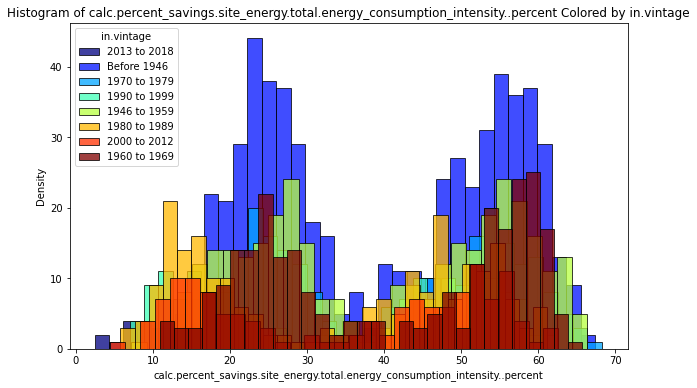

In [21]:

# Example usage with 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent' as the histogram column
# and 'in.vintage' as the category column
plot_histogram_colored_by_category_matplotlib(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.vintage')


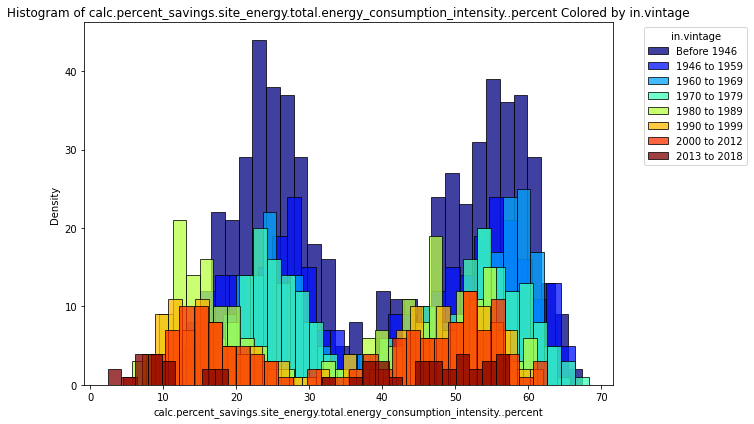

In [23]:
plot_histogram_colored_by_category_sorted(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.vintage')

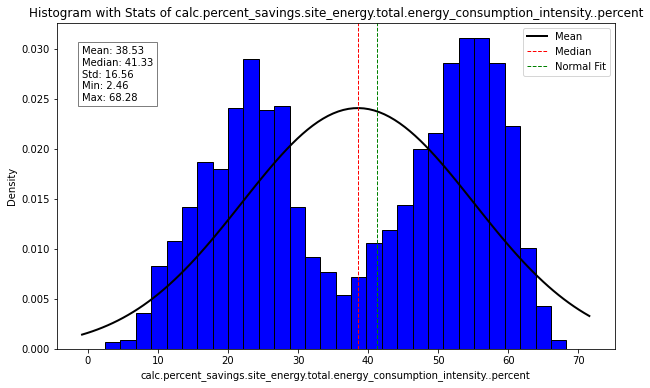

In [27]:
plot_histogram_orig(small_office_df)

In [28]:
def plot_histogram_colored_by_category_sorted(df, hist_column, category_column):
    plt.figure(figsize=(10, 6))
    
    # Count occurrences of each category and sort by this count
    category_counts = df[category_column].value_counts().index.tolist()
    
    # Assign colors based on sorted categories
    colors = plt.cm.jet(np.linspace(0, 1, len(category_counts)))
    
    # Plot histograms for each category, sorted by occurrence
    for color, category in zip(colors, category_counts):
        category_data = df[df[category_column] == category][hist_column].dropna() * 100
        n, bins, patches = plt.hist(category_data, bins=30, color=color, label=category, alpha=0.75, edgecolor='black')
    
    plt.title(f'Histogram of {hist_column} Colored and Sorted by {category_column}')
    plt.xlabel(hist_column)
    plt.ylabel('Density')
    plt.legend(title=category_column)
    plt.show()


In [29]:
def plot_total_histogram(df, hist_column):
    plt.figure(figsize=(10, 6))
    
    data = df[hist_column].dropna() * 100
    n, bins, patches = plt.hist(data, bins=30, color='gray', alpha=0.75, edgecolor='black')
    
    plt.title(f'Total Histogram of {hist_column}')
    plt.xlabel(hist_column)
    plt.ylabel('Density')
    plt.show()


In [50]:
def plot_total_histogram_category(df, hist_column):
    plt.figure(figsize=(10, 6))
    
    # Count the frequency of each category
    category_counts = df[hist_column].value_counts()
    
    # Plot using seaborn's countplot for a neat categorical histogram
    sns.barplot(x=category_counts.index, y=category_counts.values, color='gray', edgecolor='black')
    
    plt.xticks(rotation=45)  # Rotate x-axis labels to 45 degrees for better readability
    plt.title(f'Total Histogram of {hist_column}')
    plt.xlabel(hist_column)
    plt.ylabel('Count')  # Since we're dealing with counts of categories, 'Count' is more appropriate than 'Density'
    plt.tight_layout()  # Adjust layout to make room for rotated labels
    plt.show()

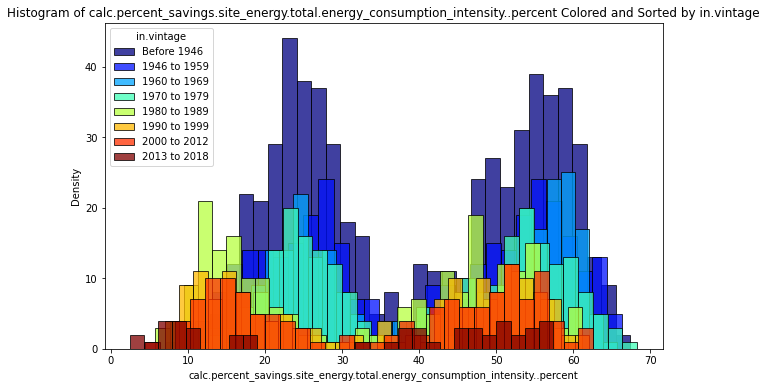

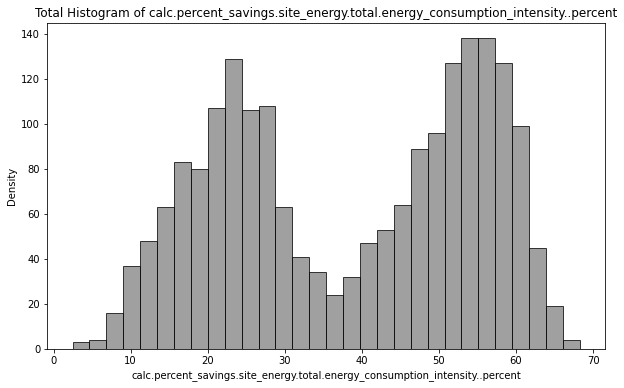

In [30]:
# Plotting categorized histogram sorted by frequency
plot_histogram_colored_by_category_sorted(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.vintage')

# Plotting total histogram for comparison
plot_total_histogram(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent')


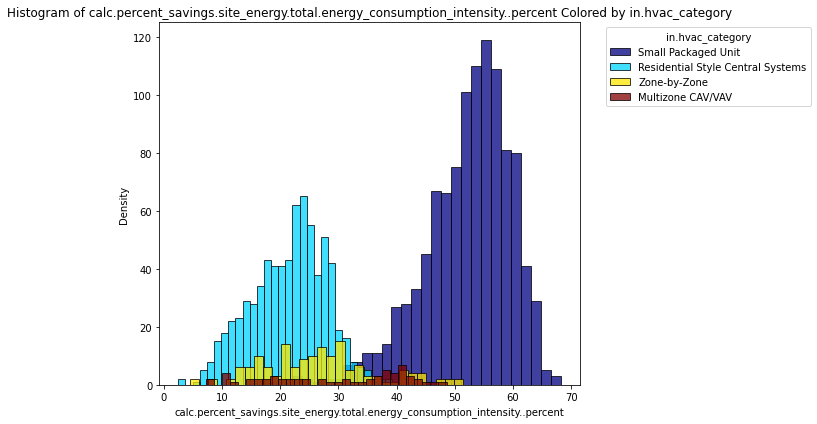

In [34]:
plot_histogram_colored_by_category_sorted_1(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.hvac_category')

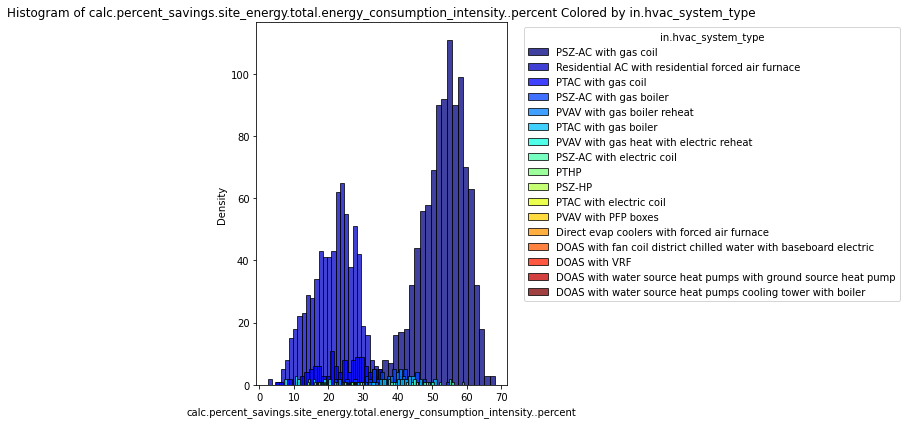

In [35]:
plot_histogram_colored_by_category_sorted_1(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.hvac_system_type')

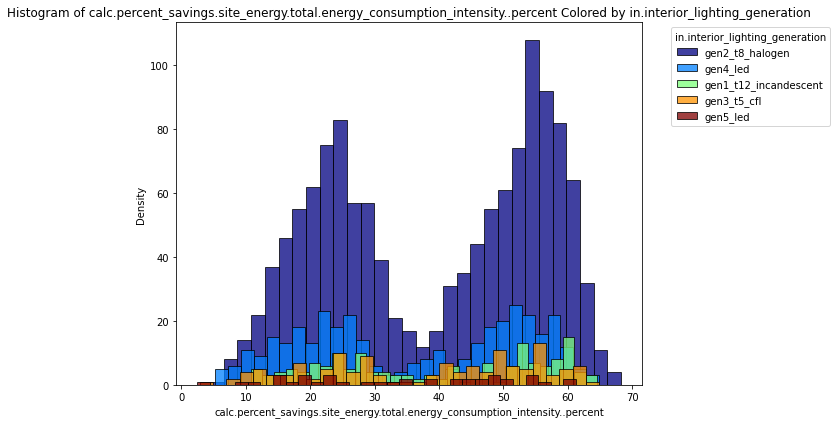

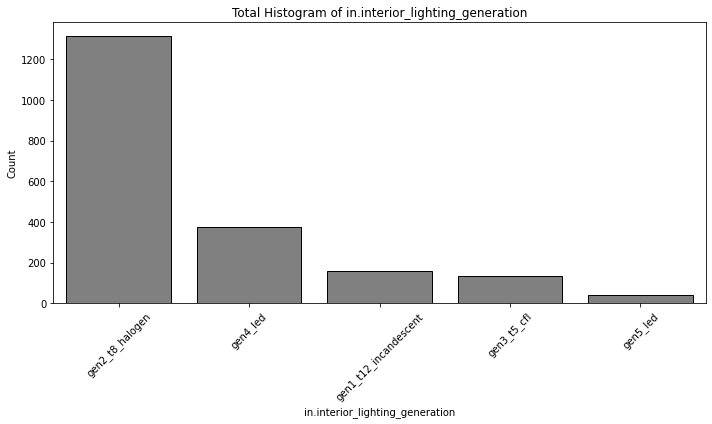

In [61]:
plot_histogram_colored_by_category_sorted_1(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.interior_lighting_generation')
plot_total_histogram_category(small_office_df, 'in.interior_lighting_generation')

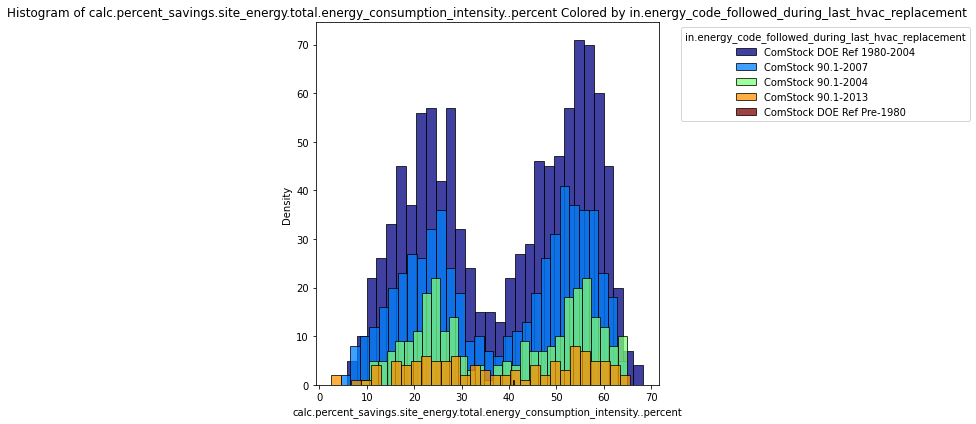

In [44]:
plot_histogram_colored_by_category_sorted_1(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.energy_code_followed_during_last_hvac_replacement')

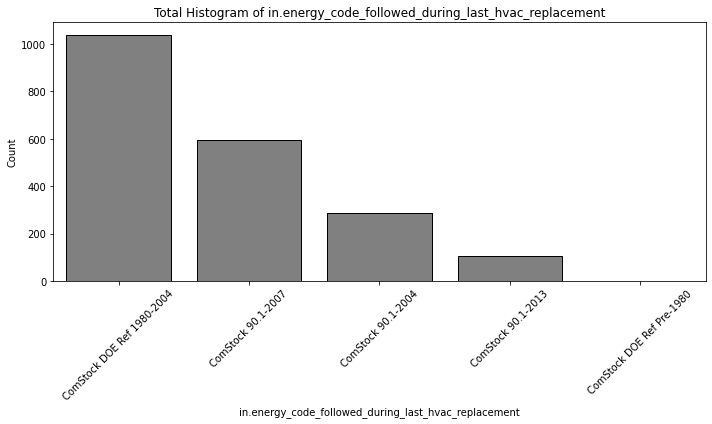

In [51]:
plot_total_histogram_category(small_office_df, 'in.energy_code_followed_during_last_hvac_replacement')

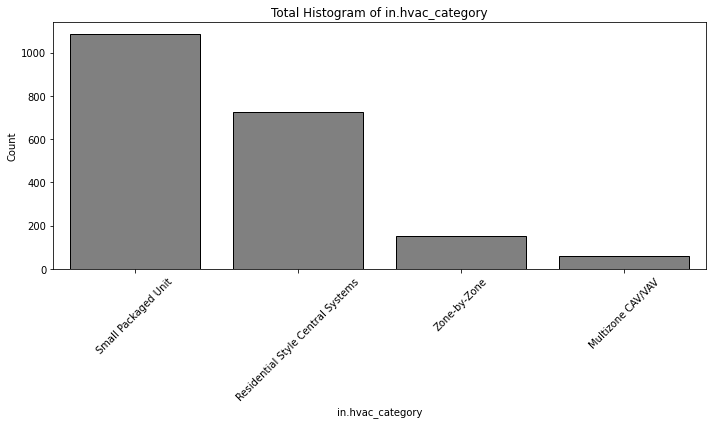

In [56]:
plot_total_histogram_category(small_office_df, 'in.hvac_category')

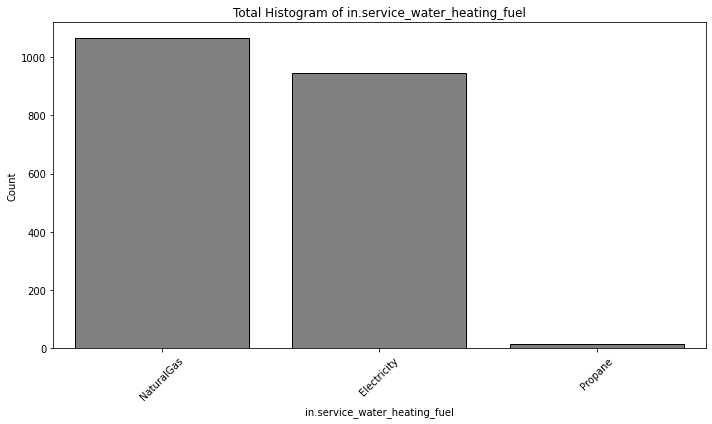

In [65]:
plot_total_histogram_category(small_office_df, 'in.service_water_heating_fuel')

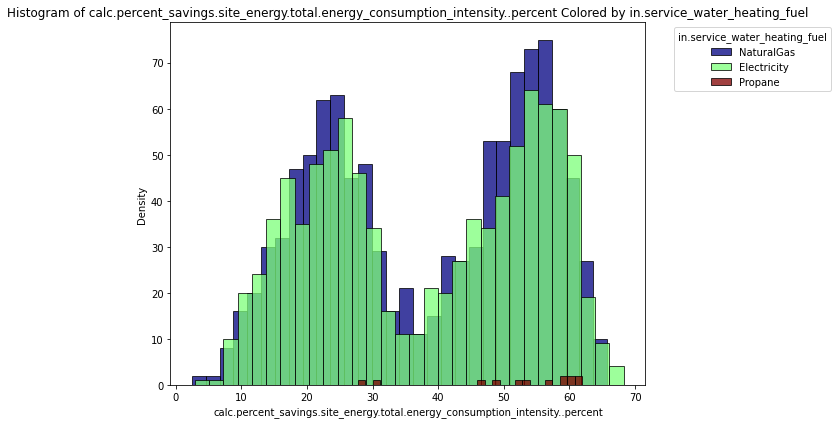

In [66]:
plot_histogram_colored_by_category_sorted_1(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.service_water_heating_fuel')

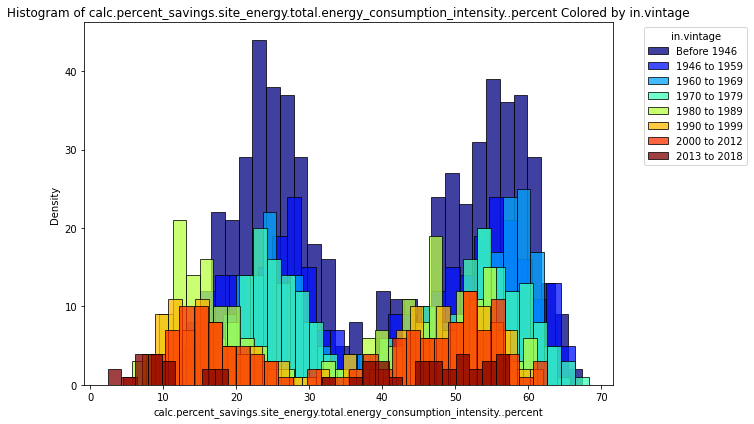

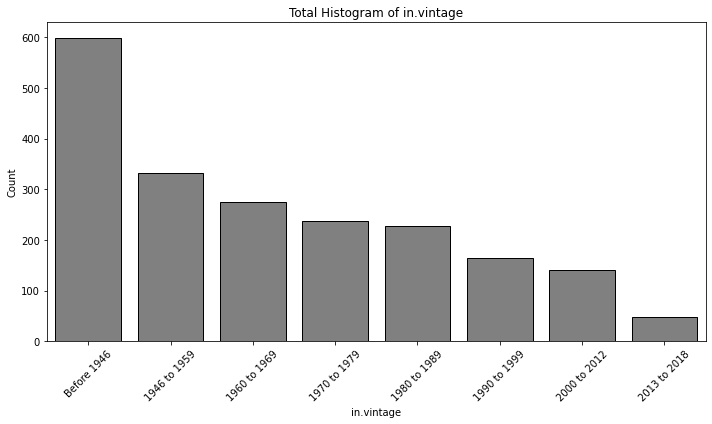

In [67]:
plot_histogram_colored_by_category_sorted_1(small_office_df, 'calc.percent_savings.site_energy.total.energy_consumption_intensity..percent', 'in.vintage')
plot_total_histogram_category(small_office_df, 'in.vintage')

In [69]:
# Compute the overall mean
overall_mean = small_office_df['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Compute means by category
category_means = small_office_df.groupby('in.hvac_category')['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Print overall mean for reference
print(f"Overall Mean: {overall_mean}")

# Print means by category
print("Means by Category:")
print(category_means)

# Assess differences
# This is a simple comparison, for illustrative purposes
differences = category_means - overall_mean
print("Differences from Overall Mean:")
print(differences)

Overall Mean: 0.38529492570454055
Means by Category:
in.hvac_category
Multizone CAV/VAV                    0.297591
Residential Style Central Systems    0.214531
Small Packaged Unit                  0.521154
Zone-by-Zone                         0.265992
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64
Differences from Overall Mean:
in.hvac_category
Multizone CAV/VAV                   -0.087704
Residential Style Central Systems   -0.170764
Small Packaged Unit                  0.135859
Zone-by-Zone                        -0.119303
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64


In [52]:
# Compute the overall mean
overall_mean = small_office_df['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Compute means by category
category_means = small_office_df.groupby('in.energy_code_followed_during_last_hvac_replacement')['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Print overall mean for reference
print(f"Overall Mean: {overall_mean}")

# Print means by category
print("Means by Category:")
print(category_means)

# Assess differences
# This is a simple comparison, for illustrative purposes
differences = category_means - overall_mean
print("Differences from Overall Mean:")
print(differences)

Overall Mean: 0.38529492570454055
Means by Category:
in.energy_code_followed_during_last_hvac_replacement
ComStock 90.1-2004            0.395693
ComStock 90.1-2007            0.377813
ComStock 90.1-2013            0.374941
ComStock DOE Ref 1980-2004    0.387747
ComStock DOE Ref Pre-1980     0.409180
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64
Differences from Overall Mean:
in.energy_code_followed_during_last_hvac_replacement
ComStock 90.1-2004            0.010398
ComStock 90.1-2007           -0.007482
ComStock 90.1-2013           -0.010354
ComStock DOE Ref 1980-2004    0.002452
ComStock DOE Ref Pre-1980     0.023885
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64


In [53]:
# Compute the overall mean
overall_mean = small_office_df['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Compute means by category
category_means = small_office_df.groupby('in.hvac_category')['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Print overall mean for reference
print(f"Overall Mean: {overall_mean}")

# Print means by category
print("Means by Category:")
print(category_means)

# Assess differences
# This is a simple comparison, for illustrative purposes
differences = category_means - overall_mean
print("Differences from Overall Mean:")
print(differences)

Overall Mean: 0.38529492570454055
Means by Category:
in.hvac_category
Multizone CAV/VAV                    0.297591
Residential Style Central Systems    0.214531
Small Packaged Unit                  0.521154
Zone-by-Zone                         0.265992
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64
Differences from Overall Mean:
in.hvac_category
Multizone CAV/VAV                   -0.087704
Residential Style Central Systems   -0.170764
Small Packaged Unit                  0.135859
Zone-by-Zone                        -0.119303
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64


In [62]:
# Compute the overall mean
overall_mean = small_office_df['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Compute means by category
category_means = small_office_df.groupby('in.interior_lighting_generation')['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Print overall mean for reference
print(f"Overall Mean: {overall_mean}")

# Print means by category
print("Means by Category:")
print(category_means)

# Assess differences
# This is a simple comparison, for illustrative purposes
differences = category_means - overall_mean
print("Differences from Overall Mean:")
print(differences)

Overall Mean: 0.38529492570454055
Means by Category:
in.interior_lighting_generation
gen1_t12_incandescent    0.394943
gen2_t8_halogen          0.393120
gen3_t5_cfl              0.376365
gen4_led                 0.360899
gen5_led                 0.347409
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64
Differences from Overall Mean:
in.interior_lighting_generation
gen1_t12_incandescent    0.009648
gen2_t8_halogen          0.007825
gen3_t5_cfl             -0.008930
gen4_led                -0.024396
gen5_led                -0.037886
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64


In [68]:
# Compute the overall mean
overall_mean = small_office_df['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Compute means by category
category_means = small_office_df.groupby('in.vintage')['calc.percent_savings.site_energy.total.energy_consumption_intensity..percent'].mean()

# Print overall mean for reference
print(f"Overall Mean: {overall_mean}")

# Print means by category
print("Means by Category:")
print(category_means)

# Assess differences
# This is a simple comparison, for illustrative purposes
differences = category_means - overall_mean
print("Differences from Overall Mean:")
print(differences)

Overall Mean: 0.38529492570454055
Means by Category:
in.vintage
1946 to 1959    0.401365
1960 to 1969    0.409081
1970 to 1979    0.403809
1980 to 1989    0.334716
1990 to 1999    0.345978
2000 to 2012    0.353882
2013 to 2018    0.332675
Before 1946     0.399770
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64
Differences from Overall Mean:
in.vintage
1946 to 1959    0.016070
1960 to 1969    0.023786
1970 to 1979    0.018514
1980 to 1989   -0.050579
1990 to 1999   -0.039317
2000 to 2012   -0.031413
2013 to 2018   -0.052620
Before 1946     0.014475
Name: calc.percent_savings.site_energy.total.energy_consumption_intensity..percent, dtype: float64


In [ ]:
# loop over upgrades
for upgrade in test_upgrades:
    UP = str(upgrade)
    up = f"{int(upgrade):02}"  # Convert string to int and format with leading zero

    data_df = pd.DataFrame(columns=['upgrade', 'state', 'comstock_building_type', 'percentage_above_25', 'percentage_above_50'])

    # Loop through each state abbreviation
    for state in test_state_abv.values():
        # Construct the local file path
        directory = f'annual/data/{up}'
        os.makedirs(directory, exist_ok=True)  # Ensure the directory exists
        file_path = f'{directory}/{state.upper()}_upgrade{up}_metadata_and_annual_results.csv'

        # Check if the file exists locally
        if os.path.exists(file_path):
            print(f"Using local file for upgrade: {up}, state: {state}")
            df = pd.read_csv(file_path, low_memory=False)
        else:
            # If the file doesn't exist, construct the URL and download the file
            url = base_url.format(up=up, STATE=state.upper())
            print(f"URL: {url}")
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    print(f"Downloading upgrade: {up}, state: {state}")
                    # Convert the CSV content to a DataFrame
                    csv_content = StringIO(response.content.decode('utf-8'))
                    df = pd.read_csv(csv_content, low_memory=False)
                    
                    # Save the DataFrame locally for future use
                    df.to_csv(file_path, index=False)
                    print(f"Saved {file_path}")
                else:
                    print(f"Failed to download data for {state.upper()}: HTTP {response.status_code}")
            except Exception as e:
                print(f"Error downloading data for {state.upper()}: {e}")          


        # Group by 'in.comstock_building_type'
        grouped = df.groupby('in.comstock_building_type')

        # Iterate over each group, filter columns that match the defined columns, and save as separate files
        for building_type, group in grouped:
            # Filter columns that match the defined columns
            filtered_df = group[columns].dropna(how='all')  # Optionally, remove rows where all selected columns are NaN

            #make histogram plot and compute %buildings above 25% savings
            percentage_above_25, percentage_above_50 = plot_histogram_with_stats_and_fit(filtered_df)
            new_data = {
                'upgrade': [up],
                'state': [state.upper()],
                'comstock_building_type': [building_type],
                'percentage_above_25': [percentage_above_25],
                'percentage_above_50': [percentage_above_50]
            }

            # add new entry to DF
            new_row_df = pd.DataFrame(new_data)
            data_df = pd.concat([data_df, new_row_df], ignore_index=True)
    print(f'saving {up}_data.csv')                
    data_df.to_csv(f'annual_explore/data/{up}/{up}_data.csv', index=False)          